In [1]:
# Import necessary libraries and classes
import os
from data_prep import HiKDataset
from torch.utils.data import DataLoader
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch

# Load the dataset
dataset_A = HiKDataset(
    dataset="A",
    data_location="data",
    sample_length=30,
    step_size=30,
    downsample_rate=6
)
dataset_B = HiKDataset(
    dataset="B",
    data_location="data",
    sample_length=30,
    step_size=30,
    downsample_rate=6
)

datasets= [dataset_A,dataset_B]
# Extract poses and labels
poses = []
labels = []
for dataset in datasets:
    for data in dataset:
        poses.append(data["poses"].numpy())
        labels.append(data["activity_label"].numpy())

poses = np.array(poses)
labels = np.array(labels)



100%|██████████| 319/319 [00:04<00:00, 76.38it/s]


In [2]:
# Convert one-hot encoded labels to single class labels
labels_single_class = np.argmax(labels, axis=1)

# Print shape after conversion
print(f"Labels single class shape: {labels_single_class.shape}")

# Encode labels to ensure they are in a supported format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_single_class)

# Print shape after encoding
print(f"Labels encoded shape: {labels_encoded.shape}")

# Ensure that the labels and poses are correctly aligned
assert len(poses) == len(labels_encoded), "Poses and labels must be of the same length"

# Reshape poses to 2D for oversampling
n_samples, n_frames, n_xyz, n_joints = poses.shape
poses_reshaped = poses.reshape(n_samples, -1)

# Perform oversampling to balance the classes
ros = RandomOverSampler()
poses_resampled, labels_resampled = ros.fit_resample(poses_reshaped, labels_encoded)

# Reshape poses back to original shape
poses_resampled = poses_resampled.reshape(-1, n_frames, n_xyz, n_joints)

# Create a balanced dataset
class BalancedHiKDataset(HiKDataset):
    def __init__(self, poses, labels):
        self.poses = poses
        self.labels = labels

    def __len__(self):
        return len(self.poses)

    def __getitem__(self, idx):
        return {
            "poses": torch.tensor(self.poses[idx], dtype=torch.float32),
            "activity_label": torch.tensor(self.labels[idx], dtype=torch.float32)
        }

balanced_dataset = BalancedHiKDataset(poses_resampled, labels_resampled)

# Create a DataLoader for the balanced dataset
balanced_dataloader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)

# Now you can use balanced_dataloader for training your model

Labels single class shape: (56447,)
Labels encoded shape: (56447,)


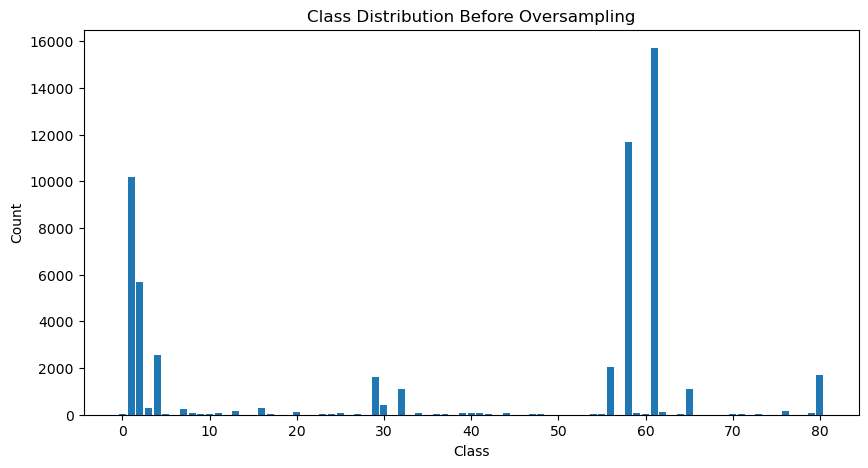

Class 0 has 36 samples
Class 1 has 10185 samples
Class 2 has 5699 samples
Class 3 has 302 samples
Class 4 has 2544 samples
Class 5 has 23 samples
Class 6 has 3 samples
Class 7 has 246 samples
Class 8 has 87 samples
Class 9 has 39 samples
Class 10 has 33 samples
Class 11 has 53 samples
Class 12 has 3 samples
Class 13 has 161 samples
Class 15 has 6 samples
Class 16 has 290 samples
Class 17 has 32 samples
Class 20 has 104 samples
Class 21 has 5 samples
Class 23 has 33 samples
Class 24 has 39 samples
Class 25 has 92 samples
Class 27 has 20 samples
Class 28 has 5 samples
Class 29 has 1612 samples
Class 30 has 406 samples
Class 32 has 1084 samples
Class 33 has 2 samples
Class 34 has 81 samples
Class 35 has 3 samples
Class 36 has 26 samples
Class 37 has 24 samples
Class 39 has 73 samples
Class 40 has 75 samples
Class 41 has 59 samples
Class 42 has 29 samples
Class 44 has 69 samples
Class 45 has 2 samples
Class 46 has 4 samples
Class 47 has 27 samples
Class 48 has 39 samples
Class 51 has 9 sam

In [4]:
import matplotlib.pyplot as plt

# Function to plot class distribution
def plot_class_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 5))
    plt.bar(unique, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()
    i=0
    for lable in unique:
        print(f"Class {lable} has {counts[i]} samples")
        i+=1



# Plot class distribution before oversampling
plot_class_distribution(labels_single_class, 'Class Distribution Before Oversampling')

NameError: name 'counts' is not defined

In [3]:
# Plot class distribution after oversampling
plot_class_distribution(labels_resampled, 'Class Distribution After Oversampling')

NameError: name 'plot_class_distribution' is not defined

In [5]:
import numpy as np
from collections import Counter

# Function to add noise to poses
def add_noise(poses, noise_level=0.01):
    noise = np.random.normal(0, noise_level, poses.shape)
    return poses + noise

# Identify classes that have more than 3000 samples
class_counts = Counter(labels_resampled)
oversampled_classes = [cls for cls, count in class_counts.items() if count > 3000]

# Add noise to oversampled classes and fix count to 3000
new_poses = []
new_labels = []

for cls in oversampled_classes:
    cls_indices = np.where(labels_resampled == cls)[0]
    np.random.shuffle(cls_indices)
    cls_indices = cls_indices[:3000]  # Fix count to 3000
    cls_poses = poses_resampled[cls_indices]
    cls_poses_noisy = add_noise(cls_poses)
    new_poses.append(cls_poses_noisy)
    new_labels.extend([cls] * 3000)

# Add the remaining classes without modification
for cls in set(labels_resampled) - set(oversampled_classes):
    cls_indices = np.where(labels_resampled == cls)[0]
    cls_poses = poses_resampled[cls_indices]
    new_poses.append(cls_poses)
    new_labels.extend([cls] * len(cls_indices))

# Convert lists to numpy arrays
new_poses = np.vstack(new_poses)
new_labels = np.array(new_labels)

# Create a balanced dataset
balanced_dataset = BalancedHiKDataset(new_poses, new_labels)

# Create a DataLoader for the balanced dataset
balanced_dataloader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)

# Now you can use balanced_dataloader for training your model

ValueError: shape mismatch: objects cannot be broadcast to a single shape

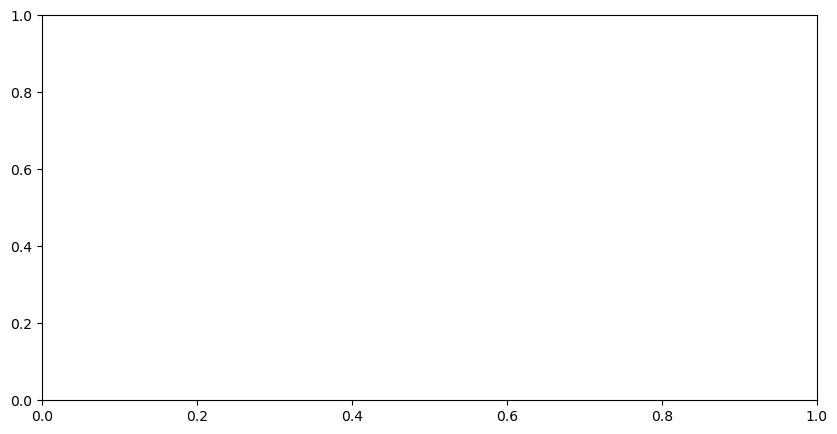

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to calculate variance for each joint coordinate across joints with the same ID
def calculate_joint_variance(poses):
    joint_variances = np.var(poses, axis=0)  # Variance across poses
    return joint_variances

# Function to calculate mean variance for each class
def calculate_mean_variance(class_poses):
    class_mean_variances = {}
    for cls, poses in class_poses.items():
        poses = np.array(poses)
        joint_variances = calculate_joint_variance(poses)
        mean_variance = np.mean(joint_variances, axis=(0, 1))  # Mean variance across all joints and coordinates
        class_mean_variances[cls] = mean_variance
    return class_mean_variances

# Aggregate poses by class
class_poses_before = defaultdict(list)
class_poses_after = defaultdict(list)
for pose, label in zip(poses, labels):
    class_poses_before[int(label[0])].append(pose)
for pose, label in zip(new_poses, new_labels):
    class_poses_after[int(label)].append(pose)

# Calculate mean variance for each class before and after noise addition
mean_variances_before = calculate_mean_variance(class_poses_before)
mean_variances_after = calculate_mean_variance(class_poses_after)

# Ensure both lists of classes are the same
classes_before = set(mean_variances_before.keys())
classes_after = set(mean_variances_after.keys())

if classes_before != classes_after:
    common_classes = classes_before.intersection(classes_after)
    mean_variances_before = {cls: mean_variances_before[cls] for cls in common_classes}
    mean_variances_after = {cls: mean_variances_after[cls] for cls in common_classes}

# Plot mean variance for comparison
def plot_mean_variance(mean_variances_before, mean_variances_after, title):
    classes = list(mean_variances_before.keys())
    mean_variance_before = [mean_variances_before[cls] for cls in classes]
    mean_variance_after = [mean_variances_after[cls] for cls in classes]

    x = np.arange(len(classes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - width/2, mean_variance_before, width, label='Before')
    ax.bar(x + width/2, mean_variance_after, width, label='After')

    ax.set_xlabel('Class')
    ax.set_ylabel('Mean Variance')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    plt.tight_layout()
    plt.show()

plot_mean_variance(mean_variances_before, mean_variances_after, 'Mean Variance of Joints by Class')